- [Data](#Data)
- [Model](#Model)
- [Training](#Training)
- [Evaluation](#Evaluation)
- [Visualization](#Visualization)

# Dependencies

In [335]:
#visualization
import matplotlib.pyplot as plt

#math tools
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import resample
from scipy.signal import decimate
#machine learning
import torch
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print(device)

#utils
from time import time
from os.path import join
from os import listdir


cuda


# Utils

In [2]:
measure2index={"y-coordinate":0,"x-coordinate":1,"timestamp":2, "button_status":3,"tilt":4, "elevation":5,"pressure":6}
index2measure=list(measure2index.keys())

task2index={"spiral":0,"l":1,"le":2 ,"les":3,"lektorka" :4,"porovnat":5,"nepopadnout":6, "tram":7}
index2task=list(task2index.keys())

In [5]:
def timeSince(since):
    now = time()
    s = now - since
    m = np.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Data
## Loading

In [6]:
data_path=join("..","PaHaW","PaHaW_public")#/00026/00026__1_1.svc"
folder_path=listdir(data_path)
folder_path.sort()

In [7]:
meta_path=join("..","PaHaW","corpus_PaHaW.csv")
meta_data=[]
with open(meta_path) as file:
    for line in file.readlines():
        meta_data.append(line.split(";"))
meta_data.pop(0)
meta_data=np.asarray(meta_data)
labels=[1 if i =="ON" else 0 for i in meta_data[:,4]]


In [8]:
#a priori unnecessary for binary classif
target=[[0,1] if i ==1 else [1,0] for i in labels]

In [9]:
task_path=listdir(join(data_path,folder_path[46]))
task_path.sort()

Subjects 46 (control),
60 (PD) and
66 (control) didn't perform the spiral !


In [10]:
raw=[]
for folder in folder_path:
    subject=[]
    task_path=listdir(join(data_path,folder))
    task_path.sort()
    if len(task_path)!=8:#subject didn't perform the spiral
        subject.append([])#add an empty array so that all tasks are on the same column number
    for task in task_path:
        measures=[]
        path=join(data_path,folder,task)
        with open(path) as file:
            for line in file.readlines():
                measures.append(line.split())
            measures.pop(0)
        subject.append(measures)
    raw.append(subject)

In [11]:
print("(75 subjects, 8 tasks, X task duration*200, 7 recorded signals)")
print(len(raw),len(raw[0]),len(raw[0][0]),len(raw[0][0][0]))

(75 subjects, 8 tasks, X task duration*200, 7 recorded signals)
75 8 1772 7


The task sequence is in average **2286** &rarr; task duration is in average 11.4s

## Exploration

spiral
l
le
les
lektorka
porovnat
nepopadnout
tram


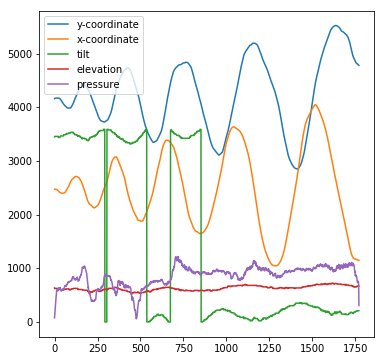

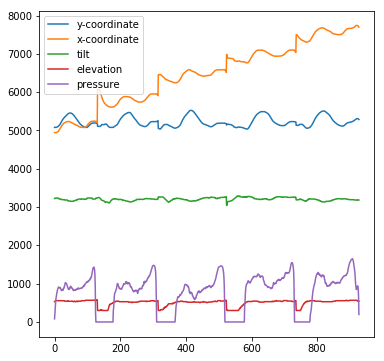

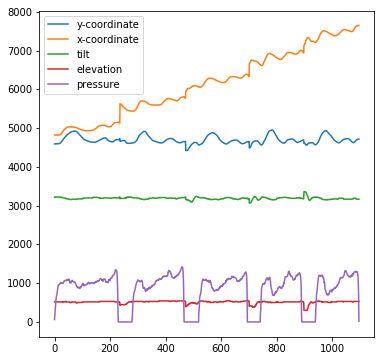

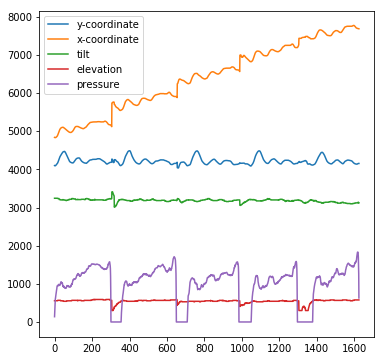

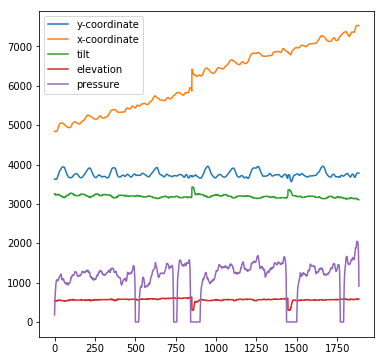

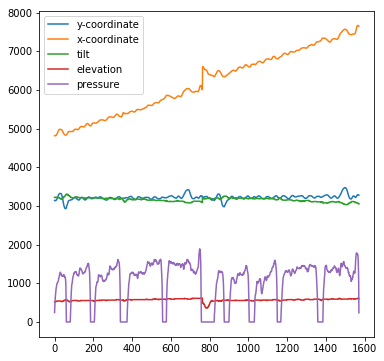

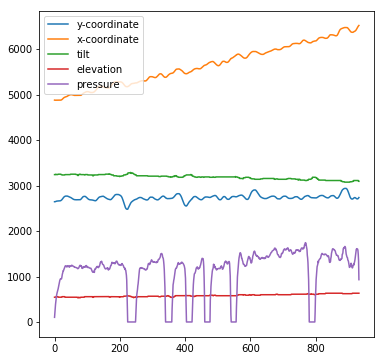

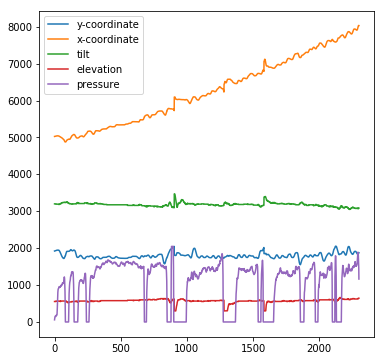

In [572]:
%matplotlib inline
subject_index=0#np.random.randint(0,len(labels))
for j in range(8):
    print(index2task[j])
    task=np.asarray(raw[subject_index][j],dtype=int)
    if task.size!=0:
        plt.figure(figsize=(6,6))
        for i in [0,1,4,5,6]:
            plt.plot(task[:,i],label=index2measure[i])
            plt.legend()
    else:
        print("Subject n° {} didn't perform {} task".format(subject_index,index2task[j]))
    

In [264]:
def DetectPause(time):
    """looks through the difference between 2 consecutives points of the timestamp of a task
    to detect if there's pauses during the recording
    
    Returns :
    - True if a Pause was detected
    - False if not"""
    timediff = [time[t+1]-time[t] for t in range(len(time)-1)]
    #print(timediff)
    for t in timediff:
        if t!=7 and t!=8:
            return True
    return False

After investigation I found that most of the exams contained (really) small pauses.  
Therefore, the timestamp measure might be useful so the model has a sense of these pauses.  

spiral
l
le
les
lektorka
porovnat
nepopadnout
tram


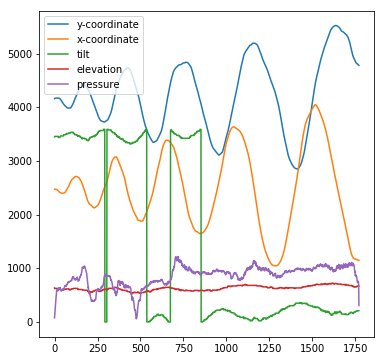

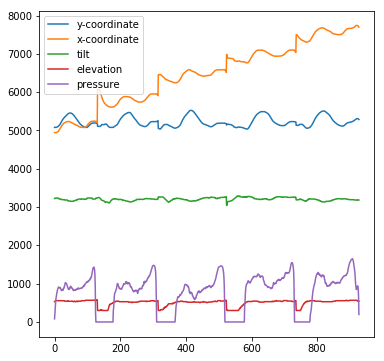

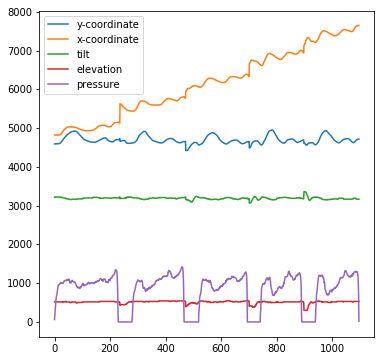

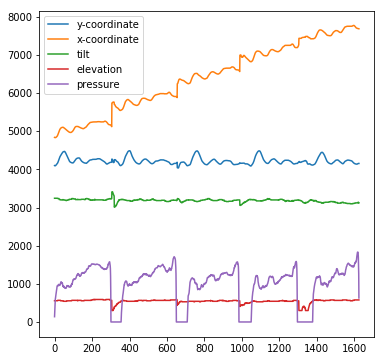

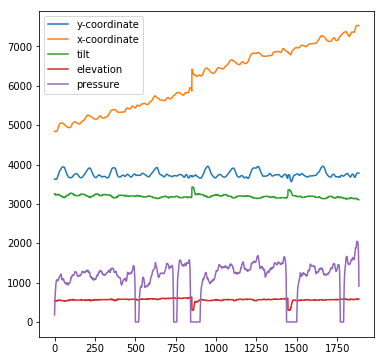

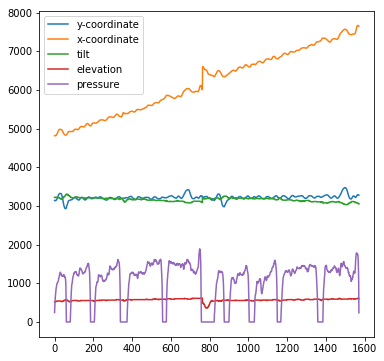

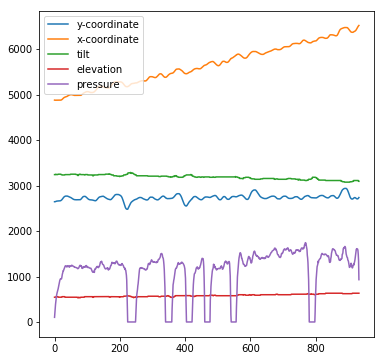

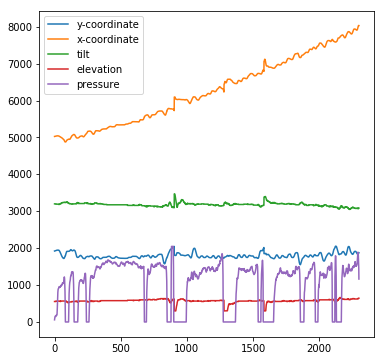

In [222]:
%matplotlib inline
subject_index=0#np.random.randint(0,len(labels))
for j in range(8):
    print(index2task[j])
    task=np.asarray(raw[subject_index][j],dtype=int)
    if task.size!=0:
        plt.figure(figsize=(6,6))
        for i in [0,1,4,5,6]:
            plt.plot(task[:,i],label=index2measure[i])
            plt.legend()
    else:
        print("Subject n° {} didn't perform {} task".format(subject_index,index2task[j]))
    

0
spiral
l
le
les
lektorka
porovnat
nepopadnout
tram


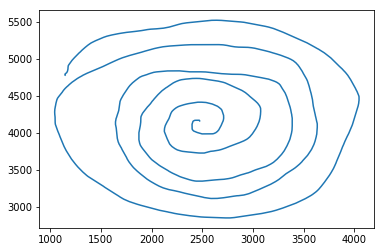

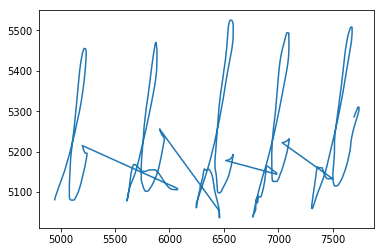

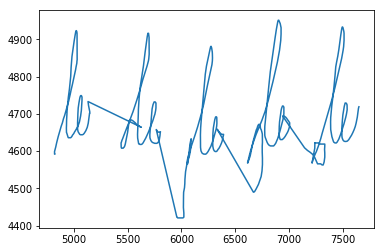

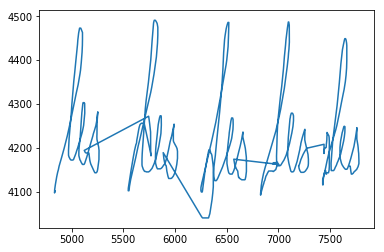

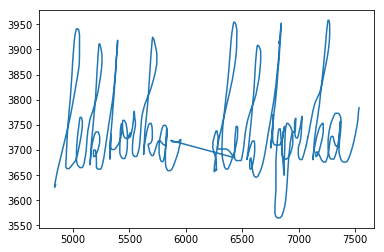

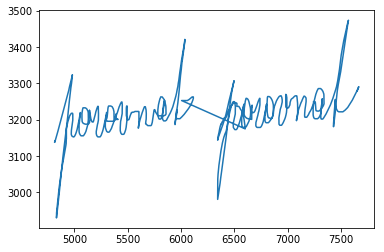

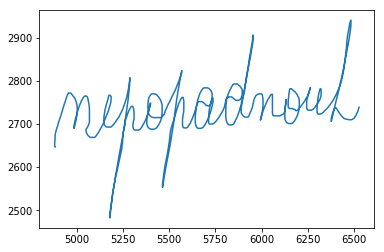

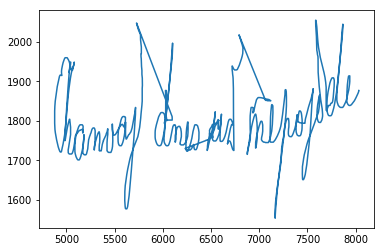

In [204]:
%matplotlib inline
subject_index=0#np.random.randint(0,len(labels))
print(subject_index)
for j in range(8):
    print(index2task[j])
    task=np.asarray(raw[subject_index][j],dtype=int)
    if task.size!=0:
        plt.figure()
        plt.plot(task[:,1],task[:,0])
    else:
        print("Subject n° {} didn't perform {} task".format(subject_index,index2task[j]))

## Preprocessing


### Standardize
along axis 0 in order to normalize all the measures independently (i.e. not all time steps independently)  
Cf. Report #4 : it's better to standardize than to normalize !

0
spiral
l
le
les
lektorka
porovnat
nepopadnout
tram


/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/

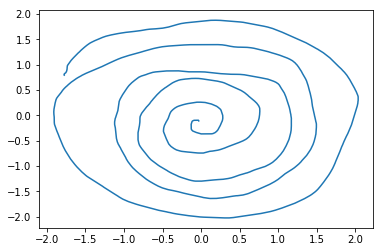

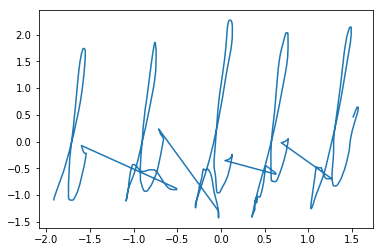

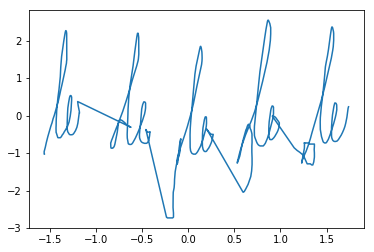

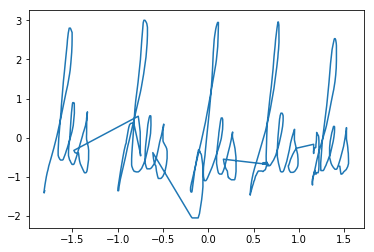

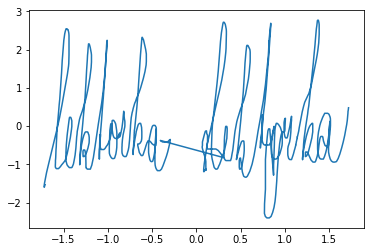

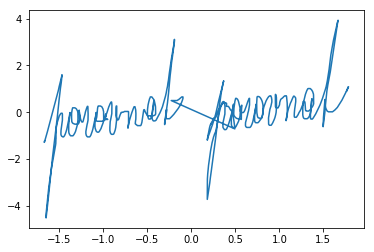

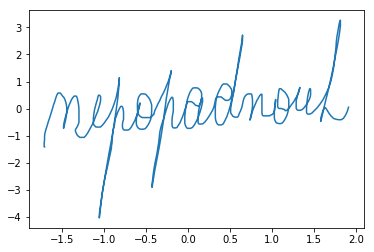

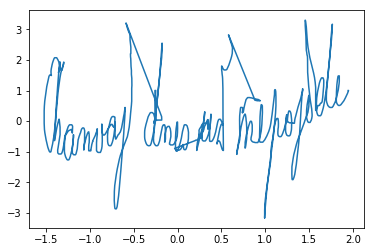

In [298]:
%matplotlib inline
subject_index=0#np.random.randint(0,len(labels))
print(subject_index)
for j in range(8):
    print(index2task[j])
    task=scale(np.asarray(raw[subject_index][j],dtype=int),axis=0)
    if task.size!=0:
        plt.figure()
        plt.plot(task[:,1],task[:,0])
    else:
        print("Subject n° {} didn't perform {} task".format(subject_index,index2task[j]))

### Dowsampling
downsamples using [SciPy's decimate](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.decimate.html).  
After experiment [SciPy's resample](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html) is ineffective as the signal is not periodic

/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


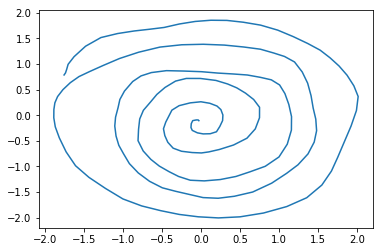

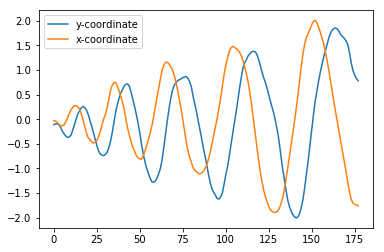

In [343]:
downsampling_factor=10#the sequence will be 10 times shorter !
task=scale(np.asarray(raw[0][0],dtype=int),axis=0)
sparse_spiral=decimate(task,downsampling_factor,axis=0)
%matplotlib inline
plt.figure()
plt.plot(sparse_spiral[:,1],sparse_spiral[:,0])
plt.figure()
for i in [0,1]:
    plt.plot(sparse_spiral[:,i],label=index2measure[i])
    plt.legend()


## Spirals

In [344]:
spirals=[raw[i][0]  for i,subject in enumerate(raw) if len(raw[i][0])!=0]#discard the subjects that didn't perform spiral

In [345]:
spiral_targets= [labels[i]  for i,subject in enumerate(raw) if len(raw[i][0])!=0]
#for multi class #
#spiral_targets=[target[i]  for i,subject in enumerate(raw) if len(raw[i][0])!=0]
#discard the subjects that didn't perform spiral

the lengths of the spirals is extremely variable :  
mean, std :  
(2873.6944444444443, 2242.0327745578024)

### Scale then downsample

In [346]:
for i,spiral in enumerate(spirals):
    spirals[i]=decimate(
        scale(np.asarray(spiral,dtype=int),axis=0),#scale first
    downsampling_factor,axis=0)#then downsample
    
print(len(spirals),len(spiral_targets))

/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/

/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/

72 72


/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/paul/anaconda3/envs/pytorch/lib/python3.7/

### Data split
In order to provide for a meaningful comparison with works from Drotar et al. and Moetesum et al. we will evaluate our results using a 10-fold cross validation  
The actual split is done before [Training](#Training)

# Model
- [**Pytorch LSTM doc**](https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM)
- [**Pytorch Linear doc**](https://pytorch.org/docs/stable/nn.html#torch.nn.Linear)
- [**Pytorch Binary Cross Entropy loss (BCELoss) doc**](https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss)

## Definition
Cf. Report #4 for details about the architecture of the model

In [376]:
class Model(torch.nn.Module):
    """
    Args:
        #Vanilla LSTM
        input_size: The number of expected features in the input `x`
        hidden_size: The number of features in the hidden state `h`
        num_layers: Number of recurrent layers. E.g., setting ``num_layers=2``
            would mean stacking two LSTMs together to form a `stacked LSTM`,
            with the second LSTM taking in outputs of the first LSTM and
            computing the final results. Default: 1
        bias: If ``False``, then the layer does not use bias weights `b_ih` and `b_hh`.
            Default: ``True``
        batch_first: If ``True``, then the input and output tensors are provided
            as (batch, seq, feature). Default: ``False``
        dropout: If non-zero, introduces a `Dropout` layer on the outputs of each
            LSTM layer except the last layer, with dropout probability equal to
            :attr:`dropout`. Default: 0
        bidirectional: If ``True``, becomes a bidirectional LSTM. Default: ``False``
        
        #our model
        batch_size : default : 1
        output_size : default : 1
    """
    def __init__(self, input_size, hidden_size,num_layers=1, bias=True,batch_first=False,
                 dropout=0,bidirectional=False, batch_size=1, output_size=1):
        super(Model, self).__init__()
        #Vanilla LSTM
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias=bias
        self.batch_first=batch_first
        self.dropout=dropout
        self.bidirectional=bidirectional
        #our model
        self.batch_size = batch_size
        self.output_size = output_size

        # Define the LSTM layer
        self.encoder = torch.nn.LSTM(self.input_size, self.hidden_size, self.num_layers,self.bias,self.batch_first,
                            self.dropout,self.bidirectional)
        
        #define the dropout layer
        self.dropout_layer=torch.nn.Dropout(self.dropout)

        # Define the decoder layer
        self.linear = torch.nn.Linear(self.hidden_size, self.output_size)
        self.sigmoid = torch.nn.Sigmoid()
                
    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of encoder_out: (seq_len, batch, num_directions * hidden_size)
        # shape of self.hidden: (h_n, c_n), where hidden state h_n and cell state c_n both 
        # have shape (num_layers * num_directions, batch, hidden_size).
        encoder_out, self.hidden = self.encoder(input)
        #print(encoder_out.shape)
        
        if self.bidirectional:
            #sums the outputs : direction left-right and direction right-left
            # encoder_out shape should now be (seq_len, batch,hidden_size)
            encoder_out = encoder_out[: ,: ,: self.hidden_size] + encoder_out[: , :, self.hidden_size: ]
        
        # Only take the output from the final timestep
        drop=self.dropout_layer(encoder_out[-1])
        y_pred = self.linear(drop)
        y_pred = self.sigmoid(y_pred)
        return y_pred.squeeze(0)
    
    def init_hidden(self):
        """h_0 of shape (num_layers * num_directions, batch, hidden_size): 
        tensor containing the initial hidden state for each element in the batch. 
        If the RNN is bidirectional, num_directions should be 2, else it should be 1.

        c_0 of shape (num_layers * num_directions, batch, hidden_size): 
        tensor containing the initial cell state for each element in the batch.
        """
        num_directions=1
        if self.bidirectional:
            num_directions=2
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers*num_directions, self.batch_size, self.hidden_size),
                torch.zeros(self.num_layers*num_directions, self.batch_size, self.hidden_size))
    
    def init_forget_bias(self):
        """Following advices of Jozefowicz et al. 2015,
        we initialize the bias of the forget gate to a large value such as 1
        In PyTorch, the forget gate bias is stored as b_hf in bias_hh_l[k] : 
        the learnable hidden-hidden bias of the kth layer (b_hi|b_hf|b_hg|b_ho), of shape (4*hidden_size).
        So b_hf == bias_hh_lk[hidden_size:2*hidden_size]
        
        The weights are modified in-place, unlike init_hidden(self).
        """
        gen=self.modules()
        _=next(gen)#model summary : don't care about it
        lstm=next(gen)
        if not isinstance(lstm,torch.nn.LSTM):
            raise NotImplementedError("the encoder should be an LSTM and should be the first module of the model")
        
        with torch.no_grad():#so the optimizer doesn't know about this ;)
            lstm.bias_hh_l0[hidden_size:2*hidden_size]=torch.ones(lstm.hidden_size)
            if lstm.bidirectional:
                lstm.bias_hh_l0_reverse[hidden_size:2*hidden_size]=torch.ones(lstm.hidden_size)
            if lstm.num_layers > 1:
                lstm.bias_hh_l1[hidden_size:2*hidden_size]=torch.ones(lstm.hidden_size)
                if lstm.bidirectional:
                    lstm.bias_hh_l1_reverse[hidden_size:2*hidden_size]=torch.ones(lstm.hidden_size)
            if lstm.num_layers > 2:
                lstm.bias_hh_l2[hidden_size:2*hidden_size]=torch.ones(lstm.hidden_size)    
                if lstm.bidirectional:
                    lstm.bias_hh_l2_reverse[hidden_size:2*hidden_size]=torch.ones(lstm.hidden_size)
            if lstm.num_layers>3:
                raise NotImplementedError("you can only have 3 layers for now")
                
    def count_params(self):
        """returns (total n° of parameters, n° of trainable parameters)"""
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        return total_params, trainable_params


# Training
## step

In [20]:
def step(input, target, model, optimizer, loss_fn, batch_size,clip=None,validation = False):
    if not validation:
        # Zero gradients
        optimizer.zero_grad()    
        
    # Set device options
    input=input.to(device)
    target=target.to(device)
        
    #forward pass
    output=model(input)
    
    # Compute loss
    loss = loss_fn(output, target)
    
    
    
    if not validation:
        # Perform backpropagation
        loss.backward()
        if clip is not None:
            #clip gradients to previent exploding
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        # Adjust model weights
        optimizer.step()
    
    return loss.item(), output.item()

## epoch

In [362]:
def epoch(data,targets, model, optimizer, loss_fn, batch_size, random_index,clip=None,validation=False):
    losses=[]
    predictions=[]
    condition_targets=[]
    
    for index in random_index:
        condition_targets.append(targets[index])
        #numpy to tensor
        subject=torch.Tensor(data[index].copy()).unsqueeze(1)#add batch dimension
        target=torch.Tensor([targets[index]])        
        loss, prediction =step(subject,target, model, optimizer, loss_fn, batch_size,clip,validation)
        predictions.append(round(prediction))
        losses.append(loss)
    
    #compute metrics
    tn, fp, fn, tp = metrics.confusion_matrix(y_true=condition_targets,y_pred=predictions,labels=[0,1]).ravel()
    accuracy= (tp+tn)/(tp+tn+fp+fn)
    sensitivity = tp/(tp+fn) if (tp+fn) != 0 else 0.0 #without condition positives the sensitivity should be 0
    specificity = tn/(tn+fp) if (tn+fp)!= 0 else 0.0 #idem
    ppv = tp/(tp+fp) if tp+fp != 0 else 0.0 #without predicted positives the ppv should be 0
    npv = tn/(tn+fn) if tn+fn !=0 else 0.0 #idem
    
    return [np.mean(losses),accuracy,sensitivity,specificity,ppv,npv]

## Hyperparameters

In [377]:
learning_rate = 1e-3
hidden_size=10
num_layers=2
bidirectional=True
dropout=0.5
clip=5.0#clipping value to clip the gradients norm : set to None if you don't want to clip

input_size=7#==len(index2measure)
bias=True
batch_first=False#we should unsqueeze(1) to add a batch dimension
batch_size=1
output_size=1#binary classif : 1 means PD, 0 means control

loss_fn=torch.nn.BCELoss()#Binary cross entropy

## 10 fold cross validation (early stopping)

In [381]:
verbose=False
skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
cv_generator=skf.split(spirals, spiral_targets)
fold_train_metrics,fold_valid_metrics=[],[]
start = time()
np.random.seed(1)
save_to_print=""
fold=0
n_epochs=50#max n° of epochs the model will be trained to
patience = 10#n° of epochs without improvement during which the model will wait before stopping

for train_index,test_index in cv_generator:     
    train_metrics,valid_metrics=[],[]
    
    torch.manual_seed(1)#random seed for weights init
    model=Model(input_size, hidden_size,num_layers, bias,batch_first,
                 dropout,bidirectional, batch_size, output_size)
    model.hidden=model.init_hidden()
    model.init_forget_bias()
    model=model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    if fold==0:        
        print("(total n° of parameters, n° of trainable parameters)\n",model.count_params())
        
    best_accuracy=0
    #best_loss=10000.0
    impatience=0
    for i in range(n_epochs):                
        to_print=""
        np.random.shuffle(train_index)
        np.random.shuffle(test_index)
        #training
        model.train()
        loss,accuracy,sensitivity,specificity,ppv,npv=epoch(
            spirals,spiral_targets, model, optimizer, loss_fn, batch_size, train_index,clip,validation=False)
        train_metrics.append([loss,accuracy,sensitivity,specificity,ppv,npv])
        to_print+="\n\nfold n°{}, epoch n°{}, spent {}".format(fold,i,timeSince(start))
        to_print+="\nTRAINING : loss {:.3f}, accuracy {:.3f}".format(loss,accuracy)

        #validation
        model.eval()
        loss,accuracy,sensitivity,specificity,ppv,npv=epoch(
            spirals,spiral_targets, model, optimizer, loss_fn, batch_size, test_index,validation=True) 
        valid_metrics.append([loss,accuracy,sensitivity,specificity,ppv,npv]) 
        to_print+="\nVALIDATION : loss {:.3f}, accuracy {:.3f}, sensitivity  {:.3f}, specificity {:.3f}, ppv {:.3f}, npv {:.3f}".format(
            loss,accuracy,sensitivity,specificity,ppv,npv)        
        
        #patience update        
        if accuracy <= best_accuracy:#`<=` no improvement is considered bad !#loss>=best_loss:
            impatience+=1
        else:
            best_accuracy=accuracy #best_loss=loss#
            impatience=0
            
        if verbose:
            print(to_print)
        save_to_print+=to_print
       
        #early stopping
        if impatience >= patience:
            save_to_print+="\nEarly stopped."
            break     
            
    fold_train_metrics.append(train_metrics)
    fold_valid_metrics.append(valid_metrics)
    fold+=1
if not verbose:
    print(save_to_print)

(total n° of parameters, n° of trainable parameters)
 (4091, 4091)


fold n°0, epoch n°0, spent 0m 5s
TRAINING : loss 0.692, accuracy 0.516
VALIDATION : loss 0.691, accuracy 0.500, sensitivity  0.250, specificity 0.750, ppv 0.500, npv 0.500

fold n°0, epoch n°1, spent 0m 10s
TRAINING : loss 0.698, accuracy 0.469
VALIDATION : loss 0.694, accuracy 0.625, sensitivity  0.500, specificity 0.750, ppv 0.667, npv 0.600

fold n°0, epoch n°2, spent 0m 15s
TRAINING : loss 0.692, accuracy 0.484
VALIDATION : loss 0.709, accuracy 0.500, sensitivity  0.500, specificity 0.500, ppv 0.500, npv 0.500

fold n°0, epoch n°3, spent 0m 20s
TRAINING : loss 0.680, accuracy 0.578
VALIDATION : loss 0.718, accuracy 0.375, sensitivity  0.250, specificity 0.500, ppv 0.333, npv 0.400

fold n°0, epoch n°4, spent 0m 25s
TRAINING : loss 0.668, accuracy 0.641
VALIDATION : loss 0.732, accuracy 0.375, sensitivity  0.250, specificity 0.500, ppv 0.333, npv 0.400

fold n°0, epoch n°5, spent 0m 30s
TRAINING : loss 0.661, accur

## 1 over 10 fold training (no early stopping)

In [378]:
skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
cv_generator=skf.split(spirals, spiral_targets)

fold=-1

In [379]:
verbose=False

fold+=1
train_metrics,valid_metrics=[],[]
train_index,test_index=next(cv_generator)
print(test_index)
print("fold n°",fold)
torch.manual_seed(1)
model=Model(input_size, hidden_size,num_layers, bias,batch_first,
                 dropout,bidirectional, batch_size, output_size)
model.hidden=model.init_hidden()
model.init_forget_bias()
model=model.to(device)
print("(total n° of parameters, n° of trainable parameters)\n",model.count_params())
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
save_to_print=""
start = time()
np.random.seed(1)


[ 3 25 41 43 58 63 65 69]
fold n° 0
(total n° of parameters, n° of trainable parameters)
 (4091, 4091)


In [380]:
for i in range(10):  
    to_print=""
    np.random.shuffle(train_index)
    np.random.shuffle(test_index)
    #training
    model.train()
    loss,accuracy,sensitivity,specificity,ppv,npv=epoch(
        spirals,spiral_targets, model, optimizer, loss_fn, batch_size, train_index,clip,validation=False)
    train_metrics.append([loss,accuracy,sensitivity,specificity,ppv,npv])
    to_print+="\n\nfold n°{}, epoch n°{}, spent {}".format(fold,i,timeSince(start))
    to_print+="\nTRAINING : loss {:.3f}, accuracy {:.3f}".format(loss,accuracy)
    
    #validation
    model.eval()
    loss,accuracy,sensitivity,specificity,ppv,npv=epoch(
        spirals,spiral_targets, model, optimizer, loss_fn, batch_size, test_index,validation=True)    
    valid_metrics.append([loss,accuracy,sensitivity,specificity,ppv,npv])
    to_print+="\nVALIDATION : loss {:.3f}, accuracy {:.3f}, sensitivity  {:.3f}, specificity {:.3f}, ppv {:.3f}, npv {:.3f}".format(
        loss,accuracy,sensitivity,specificity,ppv,npv)
    
    if verbose:
        print(to_print)    
    save_to_print+=to_print
if not verbose:
    print(save_to_print)



fold n°0, epoch n°0, spent 0m 10s
TRAINING : loss 0.683, accuracy 0.578
VALIDATION : loss 0.694, accuracy 0.625, sensitivity  0.500, specificity 0.750, ppv 0.667, npv 0.600

fold n°0, epoch n°1, spent 0m 16s
TRAINING : loss 0.691, accuracy 0.547
VALIDATION : loss 0.701, accuracy 0.500, sensitivity  0.500, specificity 0.500, ppv 0.500, npv 0.500

fold n°0, epoch n°2, spent 0m 21s
TRAINING : loss 0.685, accuracy 0.531
VALIDATION : loss 0.715, accuracy 0.500, sensitivity  0.500, specificity 0.500, ppv 0.500, npv 0.500

fold n°0, epoch n°3, spent 0m 26s
TRAINING : loss 0.684, accuracy 0.578
VALIDATION : loss 0.722, accuracy 0.375, sensitivity  0.250, specificity 0.500, ppv 0.333, npv 0.400

fold n°0, epoch n°4, spent 0m 31s
TRAINING : loss 0.670, accuracy 0.625
VALIDATION : loss 0.738, accuracy 0.375, sensitivity  0.250, specificity 0.500, ppv 0.333, npv 0.400

fold n°0, epoch n°5, spent 0m 36s
TRAINING : loss 0.670, accuracy 0.594
VALIDATION : loss 0.759, accuracy 0.375, sensitivity  0.

## Debug

In [227]:
subject=torch.Tensor(spirals[61]).unsqueeze(1)#add batch dimension
target=torch.Tensor([spiral_targets[61]])
step(subject,target, model, optimizer, loss_fn, batch_size)

# Evaluation

In [382]:
folds_lengths=[len(fold) for fold in fold_valid_metrics]
print("number of epochs before early stopping for each fold:\n",folds_lengths)
longest_fold=np.argmax(folds_lengths)
shortest_fold=np.min(folds_lengths)

number of epochs before early stopping for each fold:
 [12, 11, 12, 27, 18, 16, 11, 12, 15, 21]


In [388]:
def print_results(train_metrics,valid_metrics,early_stopping):
    train_metrics,valid_metrics=np.asarray(train_metrics),np.asarray(valid_metrics)
    print(learning_rate ,"|",hidden_size,"|",num_layers,"|",bidirectional,"|",dropout,"|",clip,"|","{:.2f} (+ {:.2f}) | {:.2f} (+ {:.2f}) ".format(
    np.mean(early_stopping),np.std(early_stopping),np.mean(train_metrics[:,1]),np.std(train_metrics[:,1])),end="")
    
    valid_metrics=valid_metrics.T
    for metric in valid_metrics[1:]:#don't care about the loss
        mean,std=np.mean(metric),np.std(metric)
        print("| {:.2f} (+ {:.2f}) ".format(mean,std),end="")


In [389]:
try:
    assert np.max([len(fold) for fold in fold_valid_metrics]) < n_epochs
except AssertionError:
    print("The model didn't early stop therefore fold[-patience-1] is not the best epoch")
else:
    print_results([fold[-patience-1] for fold in fold_train_metrics],
                  [fold[-patience-1] for fold in fold_valid_metrics],
                  [len(fold)-patience for fold in fold_valid_metrics])

0.001 | 10 | 2 | True | 0.5 | 5.0 | 5.50 (+ 4.96) | 0.58 (+ 0.11) | 0.71 (+ 0.11) | 0.57 (+ 0.31) | 0.84 (+ 0.17) | 0.75 (+ 0.29) | 0.72 (+ 0.17) 

## 10 fold cross validation with early stopping
[**Available here**](https://docs.google.com/spreadsheets/d/179afIcmJC7MUFEXo8kuTQeoRuJGvEatYPxtlvQoxZyo/edit?usp=sharing) or in the git repo.    
/!\ validating on the test set /!\  
Average metric over the 10 folds + standard deviation (i.e. we select the best epoch based on the validation accuracy for each fold)  
early stopped : n° of epochs + std  
Every metric is for the validation set if not specified otherwise  
The studied hyperparameter is printed in **bold**.  
Note : 
- the max epochs was set at 5 for the first 2 lines, 10 for the 3rd and 4rd lines and 50 for the rest 
- there was no patience for early stopping for the lines 2 to 8 but no improvement was okay : you can see the differences between line 8 and 9. They are probably explained because when we tolerated the lack of improvement, the model could wait for tens of epochs (cf. "early stopped"), overfitting until "by chance" the accuracy would went up (cf. figure below). Thus **the results of lines 7 are overoptimistic.**
- the seed for random weights initialization was not fixed for the lines 2 to 8. Therefore a direct comparison with those might be biased.  
- on the lines 2 to 12, all the biases were init randomly. You can see the difference on line 13 where we started to init the forget gate bias at 1 : it improved training accuracy, validation PPV and reduced the variance (std).  

According to these first experiments, the best learning rate is 1e-3. With 1e-4 there is more variance (std) and on some folds the model won't fit the data (cf. second figure below), we might try  it again along with regularization techniques.  
Dowsampling the data 10 times doesn't help with the overfitting as you can see on line 14 and in [Loss](#Loss).
 

 learning_rate |hidden_size|num_layers|bidirectional|dropout| gradient clipping| early stopped | TRAIN accuracy | accuracy | Se | Sp | PPV | NPV
--|--|--|--|--|--|--|--|--|--|--|--|--


#### Model overfitting until (probably) random amelioration
![overfitting until chance](overfitting_until_chance.png)
![overfitting until chance_loss](overfitting_until_chance_loss.png)
#### LR = 1e-4, model won't fit on some folds
![not_fitting_lr_1e-4](not_fitting_lr_1e-4.png)

## 5 fold cross validation with early stopping
/!\ validating on the test set /!\  
Average metric over the 5 folds + standard deviation (i.e. we select the best epoch based on the validation accuracy for each fold)  
Every metric is for the validation set if not specified otherwise 

 learning_rate |hidden_size|num_layers|bidirectional|dropout|TRAIN accuracy | accuracy | Se | Sp | PPV | NPV
--|--|--|--|--|--|--|--|--|--|--
0.001 | 100 | 1 | False | 0.0 | 0.62 (+ 0.04) | 0.60 (+ 0.05) | 0.63 (+ 0.27) | 0.56 (+ 0.35) | 0.68 (+ 0.18) | 0.50 (+ 0.26) 

## 10 fold cross validation with 1 epoch per fold

 learning_rate |hidden_size|num_layers|bidirectional|dropout|train accuracy | valid accuracy 
--|--|--|--|--|--|--
0.001 | 100 | 2 | True | 0.0 | 0.508 (+ 0.044) | 0.571 (+ 0.107) 

# Visualization

In [392]:
avg_train=np.mean(np.asarray([fold[0:shortest_fold] for fold in fold_train_metrics]),axis=0)
avg_valid=np.mean(np.asarray([fold[0:shortest_fold] for fold in fold_valid_metrics]),axis=0)

## Loss

 learning_rate |hidden_size|num_layers|bidirectional|dropout| gradient clipping| early stopped | TRAIN accuracy | accuracy | Se | Sp | PPV | NPV
--|--|--|--|--|--|--|--|--|--|--|--|--
**0.0001** | 100 | 1 | True | 0.0 | 5.0 | 14.80 (+ 12.37) | 0.63 (+ 0.09) | 0.71 (+ 0.09) | 0.55 (+ 0.27) | 0.87 (+ 0.18) | 0.88 (+ 0.15) | 0.70 (+ 0.16) 

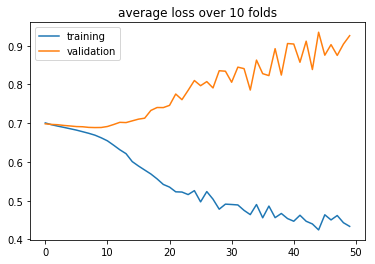

In [99]:
plt.figure()
plt.title("average loss over 10 folds")
plt.plot(avg_train[:,0],label="training")
plt.plot(avg_valid[:,0],label="validation")
plt.legend()

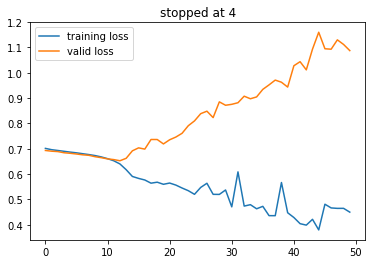

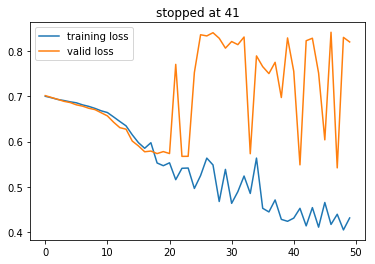

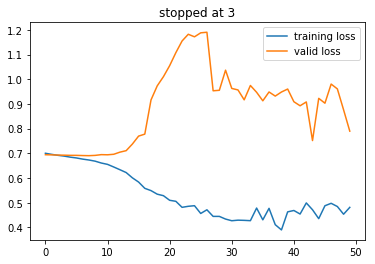

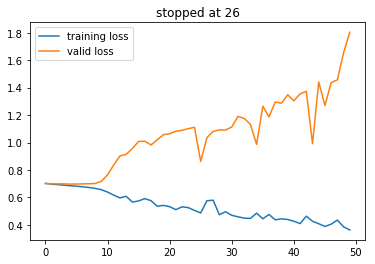

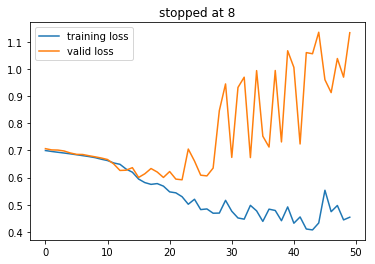

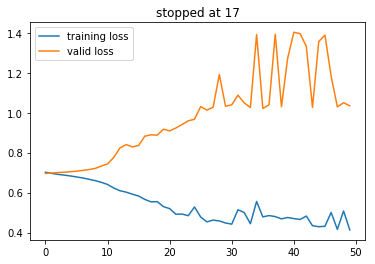

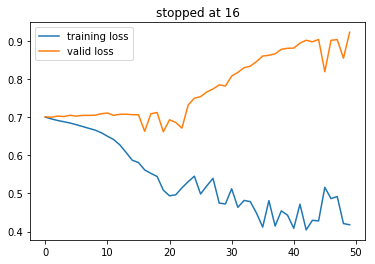

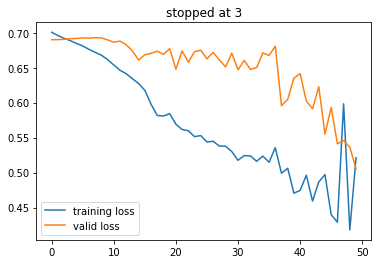

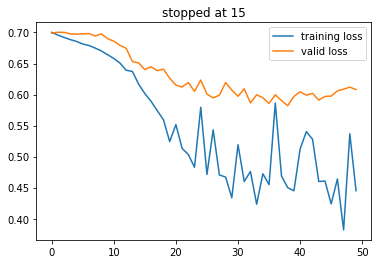

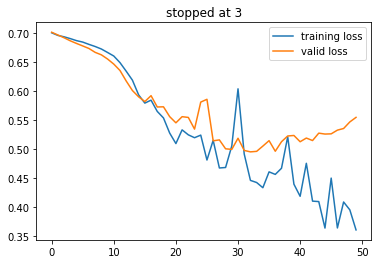

In [103]:
for i in range(10):
    plt.figure()
    plt.title("stopped at "+str(best_epochs[i]))
    plt.plot(np.asarray(fold_train_metrics[i])[:,0],label="training loss")
    plt.plot(np.asarray(fold_valid_metrics[i])[:,0],label="valid loss")
    plt.legend()

 learning_rate |hidden_size|num_layers|bidirectional|dropout| gradient clipping| early stopped | TRAIN accuracy | accuracy | Se | Sp | PPV | NPV
--|--|--|--|--|--|--|--|--|--|--|--|--
0.001 | **10** | 1 | True | 0.0 | 5.0 | 5.70 (+ 4.22) | 0.59 (+ 0.06) | 0.67 (+ 0.11) | 0.83 (+ 0.20) | 0.51 (+ 0.25) | 0.65 (+ 0.14) | 0.74 (+ 0.30)

The model seems to overfit less than usual, this is probably because it has way less parameters (~1.5k instead of ~43k)  
Adding an extra layer gives the same behaviour, more or less 

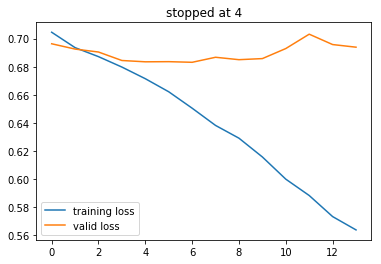

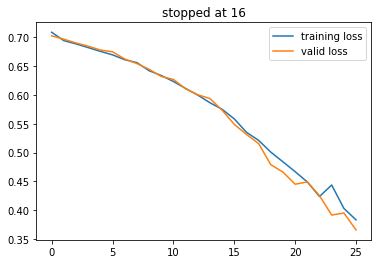

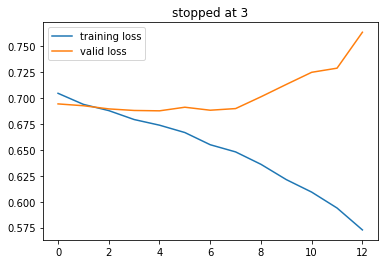

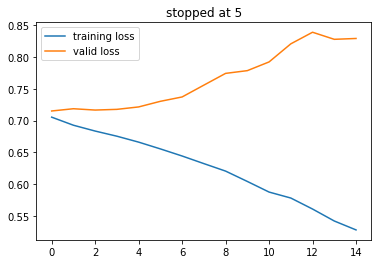

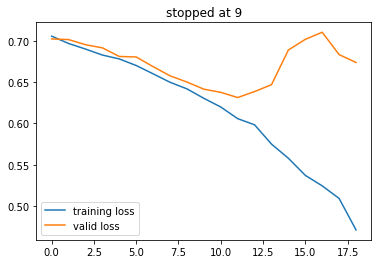

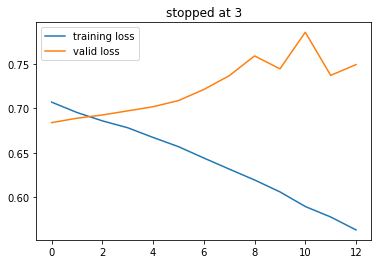

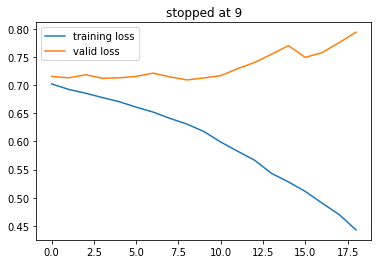

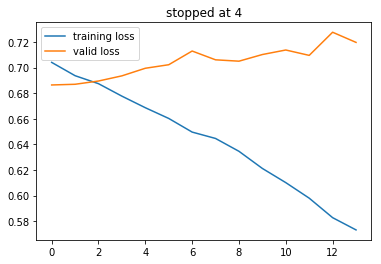

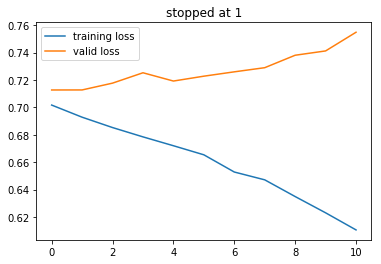

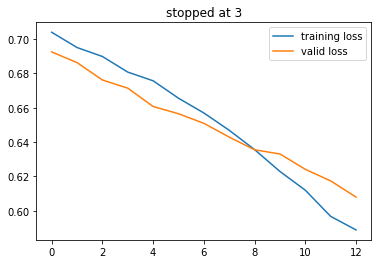

In [179]:
for i in range(10):
    plt.figure()
    plt.title("stopped at "+str(len(fold_train_metrics[i])-patience))
    plt.plot(np.asarray(fold_train_metrics[i])[:,0],label="training loss")
    plt.plot(np.asarray(fold_valid_metrics[i])[:,0],label="valid loss")
    plt.legend()

downsampling factor | learning_rate |hidden_size|num_layers|bidirectional|dropout| gradient clipping| early stopped | TRAIN accuracy | accuracy | Se | Sp | PPV | NPV
--|--|--|--|--|--|--|--|--|--|--|--|--|--
**10**|0.001 | 10 | 2 | True | 0.0 | 5.0 | 3.60 (+ 3.38) | 0.62 (+ 0.13) | 0.67 (+ 0.10) | 0.50 (+ 0.19) | 0.83 (+ 0.18) | 0.80 (+ 0.21) | 0.63 (+ 0.08) 

Downsampling the data 10 times doesn't help with the overfitting

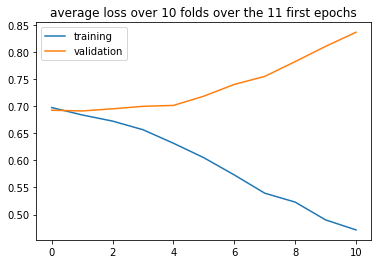

In [372]:
plt.figure()
plt.title("average loss over 10 folds over the 11 first epochs")
plt.plot(avg_train[:,0],label="training")
plt.plot(avg_valid[:,0],label="validation")
plt.legend()

##### Adding dropout between the non-recurrent layers helped with overfitting

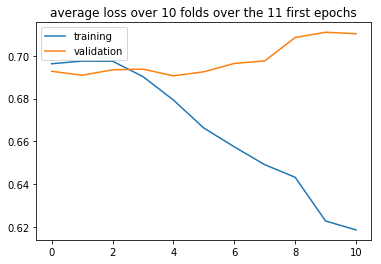

In [393]:
plt.figure()
plt.title("average loss over 10 folds over the {} first epochs".format(shortest_fold))
plt.plot(avg_train[:,0],label="training")
plt.plot(avg_valid[:,0],label="validation")
plt.legend()

## Accuracy

 learning_rate |hidden_size|num_layers|bidirectional|dropout| gradient clipping| early stopped | TRAIN accuracy | accuracy | Se | Sp | PPV | NPV
--|--|--|--|--|--|--|--|--|--|--|--|--
**0.0001** | 100 | 1 | True | 0.0 | 5.0 | 14.80 (+ 12.37) | 0.63 (+ 0.09) | 0.71 (+ 0.09) | 0.55 (+ 0.27) | 0.87 (+ 0.18) | 0.88 (+ 0.15) | 0.70 (+ 0.16) 

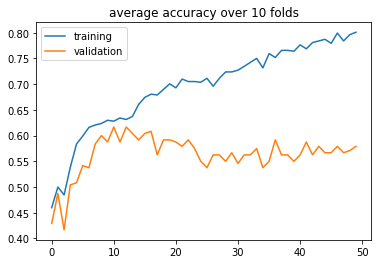

In [104]:
plt.figure()
plt.title("average accuracy over 10 folds")
plt.plot(avg_train[:,1],label="training")
plt.plot(avg_valid[:,1],label="validation")
plt.legend()

 learning_rate |hidden_size|num_layers|bidirectional|dropout| gradient clipping| early stopped | TRAIN accuracy | accuracy | Se | Sp | PPV | NPV
--|--|--|--|--|--|--|--|--|--|--|--|--
0.001 | **10** | 1 | True | 0.0 | 5.0 | 5.70 (+ 4.22) | 0.59 (+ 0.06) | 0.67 (+ 0.11) | 0.83 (+ 0.20) | 0.51 (+ 0.25) | 0.65 (+ 0.14) | 0.74 (+ 0.30)

The model seems to overfit less than usual, this is probably because it has way less parameters (~1.5k instead of ~43k)

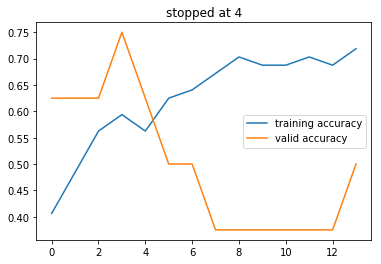

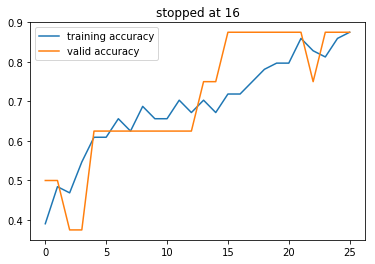

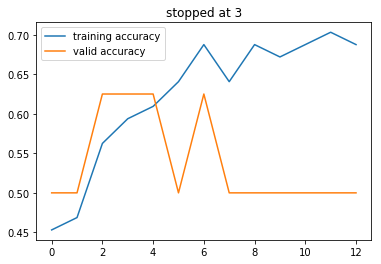

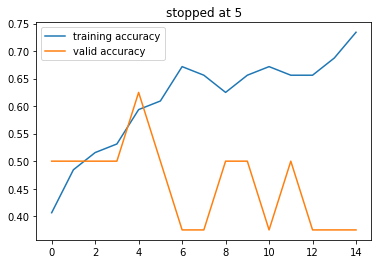

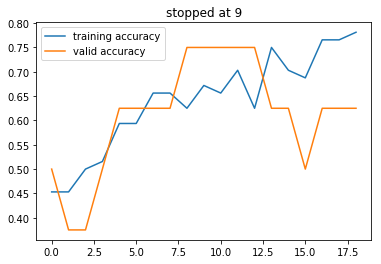

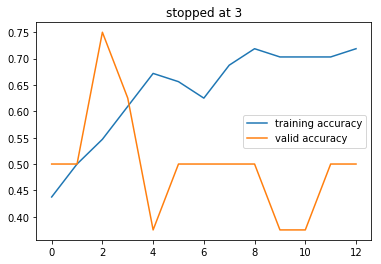

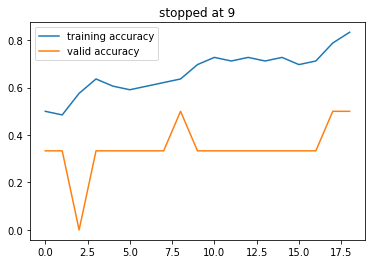

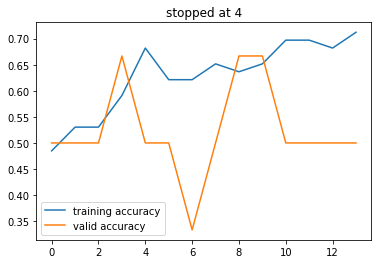

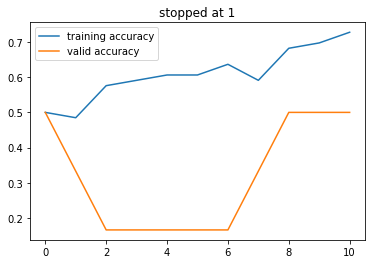

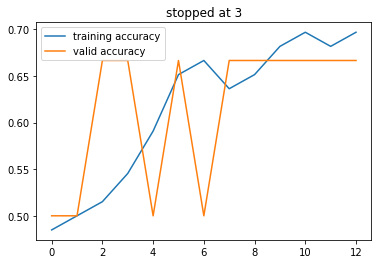

In [180]:
for i in range(10):
    plt.figure()
    plt.title("stopped at "+str(len(fold_train_metrics[i])-patience))
    plt.plot(np.asarray(fold_train_metrics[i])[:,1],label="training accuracy")
    plt.plot(np.asarray(fold_valid_metrics[i])[:,1],label="valid accuracy")
    plt.legend()

## Model weights

In [596]:
fold_train_metrics[0]

[[0.7049412904307246, 0.53125, 0.1875, 0.875, 0.6, 0.5185185185185185]]

In [533]:
generator = model.modules()
print(next(generator))
lstm=next(generator)

Model(
  (encoder): LSTM(7, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [539]:
print("""the learnable input-hidden weights of the kth layer (W_ii|W_if|W_ig|W_io) (with k=0 in our case),
of shape (4*hidden_size x input_size)""")
print(lstm.weight_ih_l0.shape)
input_weights=lstm.weight_ih_l0.cpu().detach().numpy()

the learnable input-hidden weights of the kth layer (W_ii|W_if|W_ig|W_io) (with k=0 in our case),
of shape (4*hidden_size x input_size)
torch.Size([400, 7])


#### Biases after init at 1
Interestingly, after using the trick of init the forget gate bias at 1, even after 22 epochs and an overfitted model, the bias of the forget gate are still worth ~1 :

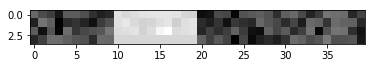

In [358]:
biases=[lstm.bias_hh_l0,
lstm.bias_hh_l0_reverse,
lstm.bias_hh_l1,
lstm.bias_hh_l1_reverse]
for i,b in enumerate(biases):
    biases[i]=b.cpu().detach().numpy()
plt.imshow(biases,cmap='gray')